In [1]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, roc_curve

# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn") # pretty matplotlib plots

In [2]:
world_model_input = pd.read_csv('world_model_input.csv')
world_model_output = pd.read_csv('world_model_output.csv')

In [3]:
# One-hot encode encoded_action, encoded_orientation, encoded_shape, and color
world_model_input = world_model_input.drop('encoded_action', 1).join(pd.get_dummies(world_model_input.encoded_action, prefix='encoded_action'))
world_model_input = world_model_input.drop('encoded_orientation', 1).join(pd.get_dummies(world_model_input.encoded_orientation, prefix='encoded_orientation'))
world_model_input = world_model_input.drop('encoded_shape', 1).join(pd.get_dummies(world_model_input.encoded_shape, prefix='encoded_shape'))
world_model_input = world_model_input.drop('encoded_color', 1).join(pd.get_dummies(world_model_input.encoded_color, prefix='encoded_color'))
world_model_input.head()

,rate,MM,vol,mag,unit_x,unit_y,unit_z,encoded_action_1,encoded_action_3,encoded_action_4,encoded_action_6,encoded_orientation_1,encoded_orientation_2,encoded_shape_1,encoded_shape_2,encoded_shape_3,encoded_color_1,encoded_color_2,encoded_color_3
0,0.10,1.0,0.1492,0.909,0.495,-0.110,-0.862,1,0,0,0,1,0,1,0,0,1,0,0
1,1.55,1.0,0.1492,0.909,0.495,-0.110,-0.862,1,0,0,0,1,0,1,0,0,1,0,0
2,3.00,1.0,0.1492,0.909,0.495,-0.110,-0.862,1,0,0,0,1,0,1,0,0,1,0,0
3,3.00,0.4,0.0217,0.885,0.508,-0.113,-0.854,0,1,0,0,0,1,0,1,0,0,1,0
4,76.50,0.4,0.0217,0.885,0.508,-0.113,-0.854,0,1,0,0,0,1,0,1,0,0,1,0


In [4]:
x = MaxAbsScaler().fit_transform(world_model_input)
#np.random.shuffle(x.T)
y = world_model_output.to_numpy()

In [5]:
def create_model():
    metrics = ['binary_accuracy', Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(19,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(6, activation='sigmoid'),
    ])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', metrics=metrics)
    return model

In [6]:
k = 5
kfold = KFold(n_splits=k)
models = []
histories = []
test_results = []
y_tests = []
predictions = []

for train_idx, test_idx in kfold.split(x):
    x_train, x_test = x[train_idx,:], x[test_idx,:]
    y_train, y_test = y[train_idx,:], y[test_idx,:]

    model = create_model()
    models.append(model)
    histories.append(model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, verbose=0))
    test_results.append(model.evaluate(x_test, y_test, verbose=0))
    y_tests.append(y_test)
    predictions.append(model.predict(x_test))

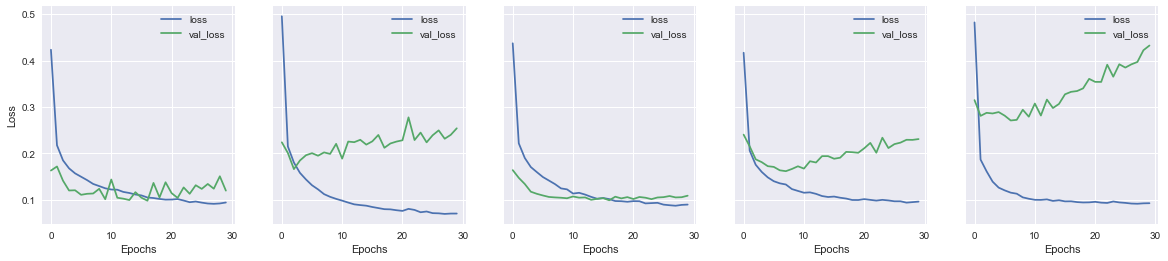

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=True)
for i in range(5):
    axs[i].plot(histories[i].history['loss'], label='loss')
    axs[i].plot(histories[i].history['val_loss'], label='val_loss')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
plt.show()

In [8]:
print("Model 1:")
train_results = [histories[0].history[m][-1] for m in models[0].metrics_names]
pd.DataFrame([train_results, test_results[0]], columns=models[0].metrics_names, index=['train', 'test']).round(2).head()

Model 1:


,loss,binary_accuracy,precision,recall,true_positives,true_negatives,false_positives,false_negatives
train,0.09,0.97,0.82,0.65,81.0,1945.0,18.0,44.0
test,0.12,0.94,0.32,0.38,8.0,484.0,17.0,13.0


In [9]:
print("Model 2:")
train_results = [histories[1].history[m][-1] for m in models[1].metrics_names]
pd.DataFrame([train_results, test_results[1]], columns=models[1].metrics_names, index=['train', 'test']).round(2).head()

Model 2:


,loss,binary_accuracy,precision_1,recall_1,true_positives_1,true_negatives_1,false_positives_1,false_negatives_1
train,0.07,0.97,0.84,0.66,80.0,1952.0,15.0,41.0
test,0.25,0.95,0.00,0.00,0.0,495.0,2.0,25.0


In [10]:
print("Model 3:")
train_results = [histories[2].history[m][-1] for m in models[2].metrics_names]
pd.DataFrame([train_results, test_results[2]], columns=models[2].metrics_names, index=['train', 'test']).round(2).head()

Model 3:


,loss,binary_accuracy,precision_2,recall_2,true_positives_2,true_negatives_2,false_positives_2,false_negatives_2
train,0.09,0.97,0.82,0.62,78.0,1946.0,17.0,47.0
test,0.11,0.96,0.57,0.19,4.0,498.0,3.0,17.0


In [11]:
print("Model 4:")
train_results = [histories[3].history[m][-1] for m in models[3].metrics_names]
pd.DataFrame([train_results, test_results[3]], columns=models[3].metrics_names, index=['train', 'test']).round(2).head()

Model 4:


,loss,binary_accuracy,precision_3,recall_3,true_positives_3,true_negatives_3,false_positives_3,false_negatives_3
train,0.10,0.97,0.81,0.52,58.0,1963.0,14.0,53.0
test,0.23,0.93,0.52,0.37,13.0,475.0,12.0,22.0


In [12]:
print("Model 5:")
train_results = [histories[4].history[m][-1] for m in models[4].metrics_names]
pd.DataFrame([train_results, test_results[4]], columns=models[4].metrics_names, index=['train', 'test']).round(2).head()

Model 5:


,loss,binary_accuracy,precision_4,recall_4,true_positives_4,true_negatives_4,false_positives_4,false_negatives_4
train,0.09,0.97,0.88,0.49,50.0,1979.0,7.0,52.0
test,0.43,0.87,0.25,0.30,13.0,440.0,38.0,31.0


In [15]:
for i in range(5):
    print("Model%2d: MSE: %5.4f"%(i+1, mean_squared_error(predictions[i], y_tests[i])))

Model 1: MSE: 0.0333
Model 2: MSE: 0.0503
Model 3: MSE: 0.0270
Model 4: MSE: 0.0525
Model 5: MSE: 0.1084
